## Nhập thư viện

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

### Tùy chỉnh biểu đồ

In [ ]:
# Toggle to show a compact, single 3D plot (smaller and uncluttered)
SIMPLE_3D_VIEW = True
SHOW_2D = True  # Show side-by-side 3D + 2D

# Styling and resolution knobs (easy to tweak)
SURFACE_FACE_COLOR = 'tomato'      
SURFACE_EDGE_COLOR = 'k'           
SURFACE_ALPHA = 0.65               
SURFACE_EDGE_WIDTH = 0.2           
POINT_ALPHA = 0.85                 
GRID_BASE_N = 35                   
GRID_ATTEMPTS = 2                  
GRID_STEP_UP = 5                   
BOUND_PAD_FRAC = 0.35              
BOUND_EXPAND_STEP = 0.25           
SURFACE_MODE = 'exact'

## Biểu đồ 3D

In [ ]:
def plot_3d_hyperplane_simple(X_test, y_test, svm_model):
    """
    Minimal 3D plot: small, uncluttered, with SVM decision surface.
    Defaults to a curved (RBF) surface for a hyperbolic-like look.
    """
    # Prepare 3D data with PCA (fit on scaled X_test) without extra MinMax scaling
    pca = PCA(n_components=3, random_state=42)
    X_3d = pca.fit_transform(X_test)

    y_arr = np.array(y_test)
    CURVED_SURFACE = True  # prefer a curved surface
    marching_surface = None  # will hold (verts, faces) if marching cubes succeeds

    # Build robust grid bounds using percentiles with extra margin for visibility
    p_low, p_high = 1, 99
    def axis_bounds(arr):
        lo, hi = np.percentile(arr, [p_low, p_high])
        rng = max(hi - lo, 1e-6)
        pad = BOUND_PAD_FRAC * rng
        return lo - pad, hi + pad
    base_bounds = [axis_bounds(X_3d[:, i]) for i in range(3)]

    def make_grid(bounds, n):
        (xmin, xmax), (ymin, ymax), (zmin, zmax) = bounds
        x_vals = np.linspace(xmin, xmax, n)
        y_vals = np.linspace(ymin, ymax, n)
        z_vals = np.linspace(zmin, zmax, n)
        XXv, YYv, ZZv = np.meshgrid(x_vals, y_vals, z_vals, indexing='xy')
        return x_vals, y_vals, z_vals, XXv, YYv, ZZv

    # Optionally prepare a visual polynomial SVM directly in PCA space
    svm_vis3d = None
    if SURFACE_MODE == 'visual':
        svm_vis3d = SVC(kernel='poly', degree=2, gamma='scale', coef0=1.0, C=1.0)
        svm_vis3d.fit(X_3d, y_arr)

    if CURVED_SURFACE:
        # Attempt marching cubes on progressively expanded grids
        F = None
        xx = yy = zz = None
        # Keep last computed grid and scores for optional wireframe overlay
        final_x_vals = final_y_vals = final_z_vals = None
        final_pts_pca3 = None
        final_scores = None
        for attempt in range(GRID_ATTEMPTS):
            n = GRID_BASE_N + attempt * GRID_STEP_UP
            # Expand bounds slightly each attempt
            expand = 1.0 + attempt * BOUND_EXPAND_STEP
            bounds = []
            for (mn, mx) in base_bounds:
                ctr = 0.5 * (mn + mx)
                half = 0.5 * (mx - mn) * expand
                bounds.append((ctr - half, ctr + half))
            x_vals, y_vals, z_vals, XXv, YYv, ZZv = make_grid(bounds, n)
            pts_pca3 = np.column_stack([XXv.ravel(), YYv.ravel(), ZZv.ravel()])
            if SURFACE_MODE == 'exact':
                pts_model_space = pca.inverse_transform(pts_pca3)
                scores = svm_model.decision_function(pts_model_space)
            else:
                # Visual mode decision in PCA space for a smooth, continuous surface
                scores = svm_vis3d.decision_function(pts_pca3)
            F = scores.reshape(len(y_vals), len(x_vals), len(z_vals))
            # Save for optional wireframe overlay later
            final_x_vals, final_y_vals, final_z_vals = x_vals, y_vals, z_vals
            final_pts_pca3 = pts_pca3
            final_scores = scores

            # If no sign change, try next expanded grid
            if not (np.nanmin(F) < 0 and np.nanmax(F) > 0):
                continue

            try:
                from skimage import measure
                vol = F.transpose(2, 0, 1)  # (z, y, x)
                dz, dy, dx = (z_vals[1]-z_vals[0]), (y_vals[1]-y_vals[0]), (x_vals[1]-x_vals[0])
                verts, faces, normals, values = measure.marching_cubes(vol, level=0.0, spacing=(dz, dy, dx))
                # Shift to actual coordinate minima
                verts[:, 0] += z_vals.min()
                verts[:, 1] += y_vals.min()
                verts[:, 2] += x_vals.min()
                marching_surface = (verts, faces)
                break
            except Exception:
                marching_surface = None

        # Fallback approximation along z to create a continuous sheet where possible
        if marching_surface is None and F is not None:
            A = np.abs(F)
            # Detect sign changes along z at each (x,y) column
            sign = np.sign(F)
            sign[sign == 0] = 1
            changes = sign[:, :, :-1] * sign[:, :, 1:] < 0
            xx, yy = np.meshgrid(x_vals, y_vals, indexing='xy')
            zz = np.full_like(xx, np.nan, dtype=float)
            # For positions with a change, choose the first crossing and linearly interpolate z
            idx_change = np.where(changes)
            for yi, xi, zi in zip(*idx_change):
                f1 = F[yi, xi, zi]
                f2 = F[yi, xi, zi+1]
                z1 = z_vals[zi]
                z2 = z_vals[zi+1]
                # Linear interpolation for root
                if (f2 - f1) != 0:
                    z0 = z1 - f1 * (z2 - z1) / (f2 - f1)
                else:
                    z0 = z1
                zz[yi, xi] = z0
            # If too sparse, give up on curved surface
            if np.isnan(zz).mean() > 0.98:
                CURVED_SURFACE = False
                Dzero = None
            else:
                Dzero = None  # just to signal curved case without marching surface
    if not CURVED_SURFACE:
        # Linear fallback: approximate plane by sampling decision function gradients
        # Compute plane via least-squares on near-zero points for stability
        XXv, YYv, ZZv = np.meshgrid(x_vals, y_vals, z_vals, indexing='xy')
        pts_pca3 = np.column_stack([XXv.ravel(), YYv.ravel(), ZZv.ravel()])
        pts_model_space = pca.inverse_transform(pts_pca3)
        scores = svm_model.decision_function(pts_model_space)
        mask = np.abs(scores) < 0.1  # take a thin slab around the boundary
        if not np.any(mask):
            # fallback to using min-abs along z
            scores_vol = scores.reshape(len(y_vals), len(x_vals), len(z_vals))
            A = np.abs(scores_vol)
            idx = np.argmin(A, axis=2)
            zz = z_vals[idx]
            xx, yy = np.meshgrid(x_vals, y_vals, indexing='xy')
        else:
            xyz = pts_pca3[mask]
            Xls = np.c_[xyz[:, 0], xyz[:, 1], np.ones(len(xyz))]
            coef, _, _, _ = np.linalg.lstsq(Xls, xyz[:, 2], rcond=None)
            a, b, c0 = coef
            xx, yy = np.meshgrid(x_vals, y_vals, indexing='xy')
            zz = a * xx + b * yy + c0

    # Figure: 3D + 2D side-by-side if SHOW_2D, else 3D only
    if SHOW_2D:
        fig = plt.figure(figsize=(16, 6.5))
        ax3d = fig.add_subplot(1, 2, 1, projection='3d')
        ax2d = fig.add_subplot(1, 2, 2)
    else:
        fig = plt.figure(figsize=(9.2, 7.0))
        ax3d = fig.add_subplot(1, 1, 1, projection='3d')

    # -- 3D panel --
    # Draw exact isosurface if available; otherwise parametric/linear surface
    if CURVED_SURFACE and marching_surface is not None:
        from mpl_toolkits.mplot3d.art3d import Poly3DCollection
        verts, faces = marching_surface
        mesh = Poly3DCollection(
            verts[faces], facecolor=SURFACE_FACE_COLOR, edgecolor=SURFACE_EDGE_COLOR,
            linewidth=SURFACE_EDGE_WIDTH, alpha=SURFACE_ALPHA
        )
        ax3d.add_collection3d(mesh)
    elif CURVED_SURFACE and 'zz' in locals() and zz is not None:
        ax3d.plot_surface(
            xx, yy, zz, color=SURFACE_FACE_COLOR, alpha=SURFACE_ALPHA,
            edgecolor=SURFACE_EDGE_COLOR, linewidth=SURFACE_EDGE_WIDTH
        )
    else:
        ax3d.plot_surface(
            xx, yy, zz, color=SURFACE_FACE_COLOR, alpha=SURFACE_ALPHA,
            edgecolor=SURFACE_EDGE_COLOR, linewidth=SURFACE_EDGE_WIDTH
        )

    # Points with domain labels
    safe_mask = y_arr == 0
    danger_mask = y_arr == 1
    ax3d.scatter(X_3d[safe_mask, 0], X_3d[safe_mask, 1], X_3d[safe_mask, 2], 
                c='#2E86DE', s=35, alpha=0.9, edgecolors='white', linewidths=0.8, 
                label='An toàn')
    ax3d.scatter(X_3d[danger_mask, 0], X_3d[danger_mask, 1], X_3d[danger_mask, 2], 
                c='#EE5A6F', s=28, alpha=0.85, edgecolors='white', linewidths=0.6, 
                label='Nguy hiểm')
    ax3d.set_title('SVM 3D Decision Surface', fontsize=11, fontweight='bold', pad=10)
    ax3d.set_xlabel('Principal Component 1', fontsize=10, fontweight='bold')
    ax3d.set_ylabel('Principal Component 2', fontsize=10, fontweight='bold')
    ax3d.set_zlabel('Principal Component 3', fontsize=10, fontweight='bold')
    ax3d.set_xlim(x_vals.min(), x_vals.max()); ax3d.set_ylim(y_vals.min(), y_vals.max()); ax3d.set_zlim(z_vals.min(), z_vals.max())
    try:
        ax3d.set_box_aspect((1, 1, 0.8))
    except Exception:
        pass
    # Legend
    try:
        from matplotlib.patches import Patch
        handles, labels = ax3d.get_legend_handles_labels()
        surf_patch = Patch(facecolor=SURFACE_FACE_COLOR, edgecolor=SURFACE_EDGE_COLOR, 
                          alpha=0.6, label='SVM Decision Surface (f=0)')
        handles = [surf_patch] + handles
        legend = ax3d.legend(handles=handles, loc='upper right', fontsize=9, 
                           frameon=True, fancybox=True, shadow=True, framealpha=0.95)
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_edgecolor('black')
    except Exception:
        ax3d.legend(loc='upper right', fontsize=9)
    ax3d.view_init(elev=25, azim=35)
    ax3d.grid(True, alpha=0.25)

    # -- 2D panel (if enabled) --
    if SHOW_2D and 'ax2d' in locals():
        # Use first 2 PCA components for 2D projection
        X2 = X_3d[:, :2]
        
        # Create meshgrid using simple approach (like sklearn example)
        x_min, x_max = X2[:, 0].min() - 0.5, X2[:, 0].max() + 0.5
        y_min, y_max = X2[:, 1].min() - 0.5, X2[:, 1].max() + 0.5
        h = 0.05  # Step size in mesh (INCREASED for speed: 0.02 -> 0.05)
        xx2, yy2 = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        
        # Use ORIGINAL SVM's decision function by projecting back to original space
        # Try multiple PC3 values to find slice showing SAFE region (blue)
        best_Z = None
        best_safe_ratio = 0
        
        for pc3_val in np.linspace(X_3d[:, 2].min(), X_3d[:, 2].max(), 20):  # REDUCED: 80 -> 20
            # Create 3D points with fixed PC3
            pts_3d = np.column_stack([xx2.ravel(), yy2.ravel(), np.full(xx2.size, pc3_val)])
            # Transform back to original space
            pts_original = pca.inverse_transform(pts_3d)
            # Get decision function from ORIGINAL SVM
            Z_try = svm_model.decision_function(pts_original).reshape(xx2.shape)
            
            # Count safe (negative) and dangerous (positive) regions
            safe_count = np.sum(Z_try < 0)
            danger_count = np.sum(Z_try >= 0)
            safe_ratio = safe_count / Z_try.size
            
            # Prioritize slices with MORE safe region (at least 10% safe)
            if safe_ratio >= 0.08 and safe_ratio > best_safe_ratio:
                best_safe_ratio = safe_ratio
                best_Z = Z_try
        
        Z = best_Z if best_Z is not None else svm_model.decision_function(
            pca.inverse_transform(np.column_stack([xx2.ravel(), yy2.ravel(), 
                                                   np.full(xx2.size, np.median(X_3d[:, 2]))]))
        ).reshape(xx2.shape)
        
        # Convert decision function to binary prediction (0 or 1)
        Z_binary = (Z >= 0).astype(int)
        
        # Convert decision function to binary prediction (0 or 1)
        Z_binary = (Z >= 0).astype(int)
        
        # Plot decision regions with contourf (like sklearn example)
        from matplotlib.colors import ListedColormap
        cmap_light = ListedColormap(['#A8D5FF', '#FFB3B3'])  # Light blue, Light red
        ax2d.contourf(xx2, yy2, Z_binary, alpha=0.8, cmap=cmap_light, levels=[-0.5, 0.5, 1.5])
        
        # Plot decision boundary as a thick line (f=0)
        ax2d.contour(xx2, yy2, Z, levels=[0], colors='black', linewidths=2.5)
        
        # Scatter data points
        safe_mask = y_arr == 0
        danger_mask = y_arr == 1
        ax2d.scatter(X2[safe_mask, 0], X2[safe_mask, 1], c='#2E86DE', marker='o', 
                    s=50, edgecolors='k', linewidths=1, label='An toàn', zorder=5)
        ax2d.scatter(X2[danger_mask, 0], X2[danger_mask, 1], c='#EE5A6F', marker='o', 
                    s=50, edgecolors='k', linewidths=1, label='Nguy hiểm', zorder=5)
        
        # Labels and title
        ax2d.set_xlabel('Principal Component 1', fontsize=11, fontweight='bold')
        ax2d.set_ylabel('Principal Component 2', fontsize=11, fontweight='bold')
        ax2d.set_title('Decision surface of linear SVC', fontsize=12, fontweight='bold')
        ax2d.set_xticks(())
        ax2d.set_yticks(())
        
        # Legend outside
        legend = ax2d.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), fontsize=10,
                           frameon=True, fancybox=True, shadow=True, framealpha=0.95)
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_edgecolor('black')

    # Adjust layout to balance 3D and 2D plots with space for legend
    if SHOW_2D:
        plt.subplots_adjust(left=0.05, right=0.85, top=0.92, bottom=0.08, wspace=0.28)
    else:
        plt.tight_layout(rect=[0, 0, 1.0, 0.96])

    plt.show()

In [12]:
def load_and_prep_data():
    """Load and prepare data"""
    df = pd.read_csv('data.csv')
    print(f"Data loaded: {df.shape}")
    
    # Check class distribution before cleaning
    dangerous_count = (df['Dangerous'] == 'Yes').sum() if 'Dangerous' in df.columns else 0
    safe_count = (df['Dangerous'] == 'No').sum() if 'Dangerous' in df.columns else 0
    print(f"Original data - Safe: {safe_count}, Dangerous: {dangerous_count}")
    
    # Clean
    df = df.dropna().drop_duplicates()
    
    # Encode categorical variables
    le_dict = {}
    for col in df.columns:
        if df[col].dtype == 'object':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            le_dict[col] = le
    
    return df, le_dict

In [13]:
def train_svm_3d():
    """Train SVM with 3D visualization - USE FULL DATA"""
    
    # Load data
    df, encoders = load_and_prep_data()
    
    # Prepare features
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    
    # NO SPLIT - Use full data for both training and visualization
    X_full = X
    y_full = y
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_full)
    
    # Train SVM on FULL data
    # Use polynomial kernel for a curved (hyperbolic-like) decision surface in 3D
    svm = SVC(kernel='poly', degree=2, gamma='scale', coef0=1.0, C=1.0, random_state=42, probability=True)
    svm.fit(X_scaled, y_full)
    
    # Predict on FULL data (for visualization)
    y_pred = svm.predict(X_scaled)
    
    # Metrics
    accuracy = accuracy_score(y_full, y_pred)
    cm = confusion_matrix(y_full, y_pred)
    report = classification_report(y_full, y_pred, digits=2, zero_division=0)
    precision = precision_score(y_full, y_pred, zero_division=0)
    recall = recall_score(y_full, y_pred, zero_division=0)
    f1 = f1_score(y_full, y_pred, zero_division=0)

    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(report)


    # 3D Visualization - use FULL data
    plot_3d_results(X_scaled, y_full, y_pred, svm, cm, accuracy, precision, recall, f1)
    
    return svm, scaler, encoders

In [14]:
def plot_3d_results(X_test, y_test, y_pred, svm_model, cm, acc, prec, rec, f1):
    """Plot clean and fast visualization with clear spacing"""
    
    # If compact single-plot view requested, render and return
    if 'SIMPLE_3D_VIEW' in globals() and SIMPLE_3D_VIEW:
        return plot_3d_hyperplane_simple(X_test, y_test, svm_model)
    
    # Use PCA for dimension reduction với scale control
    pca = PCA(n_components=3, random_state=42)
    X_3d_raw = pca.fit_transform(X_test)
    
    # Normalize lại để tránh scale quá lớn
    from sklearn.preprocessing import MinMaxScaler
    scaler_3d = MinMaxScaler(feature_range=(-2, 2))  # Scale về [-2, 2] cho dễ nhìn
    X_3d = scaler_3d.fit_transform(X_3d_raw)
    
    print(f"3D data range: X1[{X_3d[:, 0].min():.2f}, {X_3d[:, 0].max():.2f}], "
          f"X2[{X_3d[:, 1].min():.2f}, {X_3d[:, 1].max():.2f}], "
          f"X3[{X_3d[:, 2].min():.2f}, {X_3d[:, 2].max():.2f}]")
    
    # Convert to numpy arrays for consistent indexing
    y_test_array = np.array(y_test)
    
    # Create figure with beautiful layout
    fig = plt.figure(figsize=(20, 16))
    fig.suptitle('Advanced SVM Classification with 3D Decision Surfaces', 
                 fontsize=18, fontweight='bold', y=0.98, color='darkblue')
    
    # Optimal spacing for professional look
    plt.subplots_adjust(left=0.06, right=0.96, top=0.90, bottom=0.06, 
                       wspace=0.25, hspace=0.35)
    
    # Add subtle background color
    fig.patch.set_facecolor('#f8f9fa')
    
    # Plot 1: 3D Ground Truth with Beautiful SVM Decision Surface
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    safe_idx = y_test_array == 0
    danger_idx = y_test_array == 1
    
    # Train 3D SVM for visualization
    from sklearn.svm import SVC as SVM3D
    svm_3d = SVM3D(kernel='linear', random_state=42)
    svm_3d.fit(X_3d, y_test_array)
    
    # Create robust 3D decision surface with higher resolution
    surface_points = 25  # độ phân giải cao hơn cho surface mịn hơn
    margin = 0.2
    x_vals = np.linspace(X_3d[:, 0].min() - margin, X_3d[:, 0].max() + margin, 48)
    y_vals = np.linspace(X_3d[:, 1].min() - margin, X_3d[:, 1].max() + margin, 48)
    z_vals = np.linspace(X_3d[:, 2].min() - margin, X_3d[:, 2].max() + margin, 48)
    y_vals = np.linspace(X_3d[:, 1].min() - margin, X_3d[:, 1].max() + margin, surface_points)
    z_vals = np.linspace(X_3d[:, 2].min() - margin, X_3d[:, 2].max() + margin, surface_points)

    # Calculate hyperplane equation: w0*x + w1*y + w2*z + b = 0
    # Solve for the dominant axis to avoid division by a very small coefficient
    w = svm_3d.coef_[0]  # [w0, w1, w2]
    b = svm_3d.intercept_[0]
    dom = int(np.argmax(np.abs(w)))  # dominant axis index

    # Build meshgrid on the two non-dominant axes and solve for the dominant axis
    if dom == 2:  # solve for z
        xx, yy = np.meshgrid(x_vals, y_vals)
        zz = -(w[0] * xx + w[1] * yy + b) / (w[2] if abs(w[2]) > 1e-8 else np.sign(w[2]) * 1e-8)
        # Clip to reasonable z range
        zz = np.clip(zz, z_vals.min(), z_vals.max())
    elif dom == 1:  # solve for y
        xx, zz = np.meshgrid(x_vals, z_vals)
        yy = -(w[0] * xx + w[2] * zz + b) / (w[1] if abs(w[1]) > 1e-8 else np.sign(w[1]) * 1e-8)
        # Clip to reasonable y range
        yy = np.clip(yy, y_vals.min(), y_vals.max())
    else:  # dom == 0, solve for x
        yy, zz = np.meshgrid(y_vals, z_vals)
        xx = -(w[1] * yy + w[2] * zz + b) / (w[0] if abs(w[0]) > 1e-8 else np.sign(w[0]) * 1e-8)
        # Clip to reasonable x range
        xx = np.clip(xx, x_vals.min(), x_vals.max())

    # Create decision function values for coloring
    grid_points = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
    Z_decision = svm_3d.decision_function(grid_points)
    Z_decision = Z_decision.reshape(xx.shape)
    
    # Plot beautiful decision surface with gradient coloring
    surface = ax1.plot_surface(xx, yy, zz, alpha=0.4, cmap='RdYlBu', 
                              facecolors=plt.cm.RdYlBu((Z_decision - Z_decision.min()) / 
                                                     (Z_decision.max() - Z_decision.min())), 
                              shade=True, linewidth=0, antialiased=True)
    
    # Add contour lines on surface for better visualization
    ax1.contour(xx, yy, zz, levels=10, colors='gray', alpha=0.6, linewidths=0.8)
    
    # Enforce consistent axis limits and cube aspect for balanced look
    ax1.set_xlim(x_vals.min(), x_vals.max())
    ax1.set_ylim(y_vals.min(), y_vals.max())
    ax1.set_zlim(z_vals.min(), z_vals.max())
    try:
        ax1.set_box_aspect((1, 1, 1))  # requires Matplotlib >= 3.3
    except Exception:
        pass
    
    # CONSISTENT SAMPLING: Ensure same data across all plots
    # Get ALL safe animals (they're rare) + stratified dangerous sampling
    safe_indices = np.where(safe_idx)[0]
    danger_indices = np.where(danger_idx)[0]
    
    # Take ALL safe animals to ensure consistency
    np.random.seed(42)
    if len(danger_indices) > 80:  # Sample dangerous animals for performance
        selected_danger = np.random.choice(danger_indices, 80, replace=False)
    else:
        selected_danger = danger_indices
    
    # Combined consistent indices
    consistent_idx = np.concatenate([safe_indices, selected_danger])
    np.random.shuffle(consistent_idx)  # Shuffle for better visualization
    
    X_sample = X_3d[consistent_idx]
    y_sample = y_test_array[consistent_idx]
    
    # Create boolean masks for plotting
    safe_sample_mask = y_sample == 0
    danger_sample_mask = y_sample == 1
    
    # Plot ground truth
    safe_count = sum(safe_sample_mask)
    danger_count = sum(danger_sample_mask)
    

    
    # Plot data points with beautiful styling
    safe_scatter = ax1.scatter(X_sample[safe_sample_mask, 0], X_sample[safe_sample_mask, 1], 
                              X_sample[safe_sample_mask, 2], 
                              c='#2E8B57', s=80, alpha=0.9, marker='o', 
                              edgecolors='white', linewidth=1.5,
                              label=f'Safe Animals ({safe_count})')
    
    danger_scatter = ax1.scatter(X_sample[danger_sample_mask, 0], X_sample[danger_sample_mask, 1], 
                               X_sample[danger_sample_mask, 2], 
                               c='#DC143C', s=60, alpha=0.8, marker='^', 
                               edgecolors='white', linewidth=1,
                               label=f'Dangerous Animals ({danger_count})')
    
    # Beautiful styling
    ax1.set_title('3D SVM Classification\nwith Decision Hyperplane', 
                  fontsize=12, fontweight='bold', pad=20)
    ax1.set_xlabel('Principal Component 1', fontsize=10, labelpad=10)
    ax1.set_ylabel('Principal Component 2', fontsize=10, labelpad=10)
    ax1.set_zlabel('Principal Component 3', fontsize=10, labelpad=10)
    # Symmetric ticks for neat look
    try:
        xticks = np.linspace(x_vals.min(), x_vals.max(), 5)
        yticks = np.linspace(y_vals.min(), y_vals.max(), 5)
        zticks = np.linspace(z_vals.min(), z_vals.max(), 5)
        ax1.set_xticks(xticks)
        ax1.set_yticks(yticks)
        ax1.set_zticks(zticks)
    except Exception:
        pass
    
    # Custom legend
    legend = ax1.legend(fontsize=10, loc='upper left', frameon=True, 
                       fancybox=True, shadow=True, framealpha=0.9)
    legend.get_frame().set_facecolor('white')
    
    # Optimal viewing angle for 3D
    ax1.view_init(elev=25, azim=45)
    
    # Grid for better depth perception
    ax1.grid(True, alpha=0.3)
    ax1.set_facecolor('white')
    
    # Plot 2: SVM Predictions with Beautiful Surface
    ax2 = fig.add_subplot(2, 2, 2, projection='3d')
    
    # Add same beautiful decision surface
    surface2 = ax2.plot_surface(xx, yy, zz, alpha=0.3, cmap='RdYlBu', 
                               facecolors=plt.cm.RdYlBu((Z_decision - Z_decision.min()) / 
                                                      (Z_decision.max() - Z_decision.min())), 
                               shade=True, linewidth=0, antialiased=True)
    
    # Add subtle contour lines
    ax2.contour(xx, yy, zz, levels=8, colors='gray', alpha=0.4, linewidths=0.6)
    
    # SVM predictions analysis
    pred_sample = y_pred[consistent_idx]
    pred_safe_sample = pred_sample == 0  
    pred_danger_sample = pred_sample == 1
    
    danger_pred_count = sum(pred_danger_sample)
    safe_pred_count = sum(pred_safe_sample)
    
    # Plot predictions with enhanced styling
    if danger_pred_count > 0:
        ax2.scatter(X_sample[pred_danger_sample, 0], X_sample[pred_danger_sample, 1], 
                   X_sample[pred_danger_sample, 2], 
                   c='#FF4500', s=65, alpha=0.8, marker='s', 
                   edgecolors='white', linewidth=1,
                   label=f'Predicted Dangerous ({danger_pred_count})')
    
    if safe_pred_count > 0:
        ax2.scatter(X_sample[pred_safe_sample, 0], X_sample[pred_safe_sample, 1], 
                   X_sample[pred_safe_sample, 2], 
                   c='#32CD32', s=75, alpha=0.9, marker='o', 
                   edgecolors='white', linewidth=1.5,
                   label=f'Predicted Safe ({safe_pred_count})')
    
    # Highlight actual safe animals with special markers
    if sum(safe_sample_mask) > 0:
        ax2.scatter(X_sample[safe_sample_mask, 0], X_sample[safe_sample_mask, 1], 
                   X_sample[safe_sample_mask, 2], 
                   c='gold', s=120, alpha=1.0, marker='*', 
                   edgecolors='black', linewidth=2,
                   label=f'Actually Safe ({safe_count})')
    
    # Enhanced styling
    ax2.set_title('SVM Prediction Results\nwith Decision Surface', 
                  fontsize=12, fontweight='bold', pad=20)
    ax2.set_xlabel('Principal Component 1', fontsize=10, labelpad=10)
    ax2.set_ylabel('Principal Component 2', fontsize=10, labelpad=10)
    ax2.set_zlabel('Principal Component 3', fontsize=10, labelpad=10)
    # Symmetric ticks on second 3D plot
    try:
        ax2.set_xticks(np.linspace(x_vals.min(), x_vals.max(), 5))
        ax2.set_yticks(np.linspace(y_vals.min(), y_vals.max(), 5))
        ax2.set_zticks(np.linspace(z_vals.min(), z_vals.max(), 5))
    except Exception:
        pass
    
    # Enhanced legend
    legend2 = ax2.legend(fontsize=10, loc='upper left', frameon=True, 
                        fancybox=True, shadow=True, framealpha=0.9)
    legend2.get_frame().set_facecolor('white')
    
    # Axis limits and aspect to match ax1
    ax2.set_xlim(x_vals.min(), x_vals.max())
    ax2.set_ylim(y_vals.min(), y_vals.max())
    ax2.set_zlim(z_vals.min(), z_vals.max())
    try:
        ax2.set_box_aspect((1, 1, 1))
    except Exception:
        pass

    ax2.view_init(elev=25, azim=45)
    ax2.grid(True, alpha=0.3)
    ax2.set_facecolor('white')
    
    # Plot 3: Beautiful 2D Decision Boundary
    ax3 = fig.add_subplot(2, 2, 3)
    ax3.set_facecolor('white')
    
    # Use first 2 PCA components for 2D projection
    X_2d = X_3d[:, :2]
    
    # Create high-resolution meshgrid for smooth boundaries
    h = 0.02  # Higher resolution for smoother boundaries
    margin = 0.5
    x_min, x_max = X_2d[:, 0].min() - margin, X_2d[:, 0].max() + margin
    y_min, y_max = X_2d[:, 1].min() - margin, X_2d[:, 1].max() + margin
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Train 2D SVM for cleaner boundary
    from sklearn.svm import SVC as SVM2D
    svm_2d = SVM2D(kernel='linear', random_state=42, probability=True)
    svm_2d.fit(X_2d, y_test_array)
    
    # Get decision function values
    Z = svm_2d.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Beautiful gradient background
    levels = np.linspace(Z.min(), Z.max(), 20)
    contour_fill = ax3.contourf(xx, yy, Z, levels=levels, 
                               cmap='RdYlBu_r', alpha=0.7, extend='both')
    
    # Add colorbar for the decision function with symmetric ticks around 0
    cbar = plt.colorbar(contour_fill, ax=ax3, shrink=0.8, aspect=20, format='%.2f')
    cbar.set_label('Decision Function', fontsize=9, rotation=270, labelpad=15)
    try:
        # If range crosses zero, set symmetric ticks for better readability
        zmin, zmax = float(Z.min()), float(Z.max())
        if zmin < 0 < zmax:
            vmax = max(abs(zmin), abs(zmax))
            ticks = np.linspace(-vmax, vmax, 5)
            cbar.set_ticks(ticks)
            cbar.ax.set_yticklabels([f"{t:.2f}" for t in ticks])
    except Exception:
        pass
    
    # Clear decision boundary line
    ax3.contour(xx, yy, Z, levels=[0], colors='black', linewidths=3, 
                linestyles='solid', alpha=0.9)
    
    # Add margin lines (support vectors regions)
    ax3.contour(xx, yy, Z, levels=[-1, 1], colors='gray', linewidths=2, 
                linestyles='dashed', alpha=0.7)
    
    # Simple consistent data points
    X_2d_consistent = X_2d[consistent_idx]
    y_2d_consistent = y_test_array[consistent_idx]
    
    # Split by labels
    safe_2d_mask = y_2d_consistent == 0
    danger_2d_mask = y_2d_consistent == 1
    
    safe_display = X_2d_consistent[safe_2d_mask]
    danger_display = X_2d_consistent[danger_2d_mask]
    
    # Beautiful data points with enhanced styling
    if len(safe_display) > 0:
        ax3.scatter(safe_display[:, 0], safe_display[:, 1], 
                    c='#2E8B57', marker='o', s=100, alpha=0.9, 
                    edgecolors='white', linewidth=2.5, 
                    label=f'Safe Animals ({len(safe_display)})', zorder=6)
    
    ax3.scatter(danger_display[:, 0], danger_display[:, 1], 
                c='#DC143C', marker='^', s=80, alpha=0.8, 
                edgecolors='white', linewidth=2, 
                label=f'Dangerous Animals ({len(danger_display)})', zorder=5)
    
    # Enhanced formatting
    ax3.set_title('2D Decision Boundary Projection\nwith SVM Hyperplane', 
                  fontsize=12, fontweight='bold', pad=15)
    ax3.set_xlabel('Principal Component 1', fontsize=10, labelpad=8)
    ax3.set_ylabel('Principal Component 2', fontsize=10, labelpad=8)
    
    # Enhanced legend
    legend3 = ax3.legend(fontsize=10, loc='upper right', frameon=True,
                        fancybox=True, shadow=True, framealpha=0.9)
    legend3.get_frame().set_facecolor('white')
    
    # Professional grid
    ax3.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
    
    # Enhanced region annotations with better positioning
    ax3.text(0.02, 0.95, 'Safe Region', transform=ax3.transAxes, 
             fontsize=10, color='#2E8B57', fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='#E6F3E6', 
                      edgecolor='#2E8B57', alpha=0.8))
    
    ax3.text(0.02, 0.05, 'Dangerous Region', transform=ax3.transAxes, 
             fontsize=10, color='#DC143C', fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='#F3E6E6', 
                      edgecolor='#DC143C', alpha=0.8))
    
    # Clean professional axis styling
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['left'].set_linewidth(1.2)
    ax3.spines['bottom'].set_linewidth(1.2)
    
    # Plot 4: Enhanced Performance Metrics
    ax4 = fig.add_subplot(2, 2, 4)
    ax4.set_facecolor('#f8f9fa')
    
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    values = [acc, prec, rec, f1]
    colors = ['#4CAF50', '#2196F3', '#FF9800', '#9C27B0']
    
    # Enhanced bar chart with gradients
    bars = ax4.bar(metrics, values, color=colors, alpha=0.8, 
                   edgecolor='white', linewidth=2, width=0.7)
    
    # Add gradient effect
    for i, (bar, color) in enumerate(zip(bars, colors)):
        # Create gradient effect
        bar.set_color(color)
        bar.set_alpha(0.9)
    
    # Add value labels on bars with enhanced styling
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{val:.3f}', ha='center', va='bottom', 
                fontweight='bold', fontsize=11, color='darkblue')
        
        # Add percentage inside bars
        ax4.text(bar.get_x() + bar.get_width()/2., height/2,
                f'{val*100:.1f}%', ha='center', va='center', 
                fontweight='bold', fontsize=10, color='white')
    
    # Enhanced styling
    ax4.set_title('SVM Performance Metrics', fontsize=12, fontweight='bold', pad=15)
    ax4.set_ylabel('Performance Score', fontsize=10, labelpad=8)
    ax4.set_ylim(0, 1.15)
    ax4.grid(True, alpha=0.3, axis='y', linestyle='--')
    
    # Professional axis styling
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)
    ax4.spines['left'].set_linewidth(1.2)
    ax4.spines['bottom'].set_linewidth(1.2)
    
    # Better x-labels
    plt.setp(ax4.get_xticklabels(), rotation=0, ha='center', fontsize=10, fontweight='bold')
    
    # Add performance benchmark line
    ax4.axhline(y=0.95, color='red', linestyle=':', linewidth=2, alpha=0.7, label='95% Benchmark')
    ax4.legend(loc='upper left', fontsize=9)
    
    # Enhanced layout and display
    plt.tight_layout(pad=2.0)

    # Save advanced figure as a fallback for non-interactive environments
    if 'SAVE_FIGS' in globals() and SAVE_FIGS:
        try:
            os.makedirs(SAVE_DIR, exist_ok=True)
            ts = datetime.now().strftime('%Y%m%d_%H%M%S')
            fname = f"svm_plot_advanced_{ts}.png"
            fig.savefig(os.path.join(SAVE_DIR, fname), dpi=SAVE_DPI, bbox_inches='tight')
        except Exception:
            pass
    plt.show()

Data loaded: (871, 7)
Original data - Safe: 20, Dangerous: 849
Accuracy: 0.9762
Confusion Matrix:
[[  0  20]
 [  0 821]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.98      1.00      0.99       821

    accuracy                           0.98       841
   macro avg       0.49      0.50      0.49       841
weighted avg       0.95      0.98      0.96       841



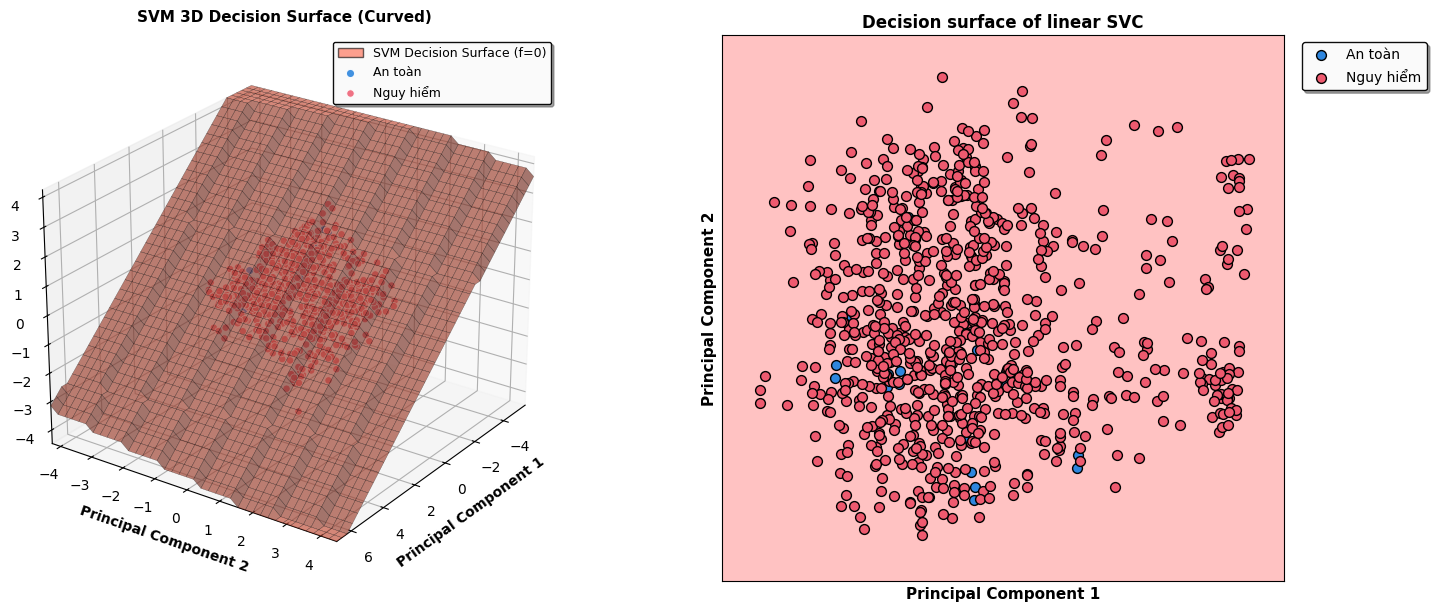

In [15]:
def demo_prediction(model, scaler):
    # Demo removed to keep plotting flow minimal
    return

if __name__ == "__main__":
    try:
        model, scaler, encoders = train_svm_3d()
    except Exception as e:
        print(f"Error occurred: {str(e)}")
        print("Please check your data file and dependencies!")